# Transfer Learning with TensorFlow Part 1: Feature Extraction

Transfer learning is leveraging a working model's existing architecture and learned patterns for our own problem.

There are two main benefits:
1. Can leverage an existing neural network architecture proven to work on problems similar to our own.
2. Can leverage a working neural network architecture which has already learned patterns on similar data to our own, then we can adapt thos patterns to our own data.

In [1]:
# Are we using a GPU?
!nvidia-smi

Fri Apr 12 12:53:14 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   56C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## Downloading the data

In [2]:
# Get data (10% of 10  food classes from Food101) - https://www.kaggle.com/datasets/dansbecker/food-101
import zipfile

# Download the data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

# Unzip the downloaded file
zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip")
zip_ref.extractall()
zip_ref.close()

--2024-04-12 12:53:20--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.253.118.207, 74.125.200.207, 74.125.130.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.253.118.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M  23.1MB/s    in 8.0s    

2024-04-12 12:53:29 (20.1 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [3]:
# How many images in each folder?
import os

# Walk through 10 percent data directory and list number of files
for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '10_food_classes_10_percent

## Creating data loaders (preparing the data)

We'll use the 'ImageDataGenerator class to load in our images in batches

In [4]:
# Setup data inputs
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32

train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

print("Training images: ")
train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                                          target_size = IMAGE_SHAPE,
                                                          batch_size=BATCH_SIZE,
                                                          class_mode="categorical")

print("Testing images: ")
test_data = test_datagen.flow_from_directory(test_dir,
                                             target_size=IMAGE_SHAPE,
                                             batch_size=BATCH_SIZE,
                                             class_mode="categorical")



Training images: 
Found 750 images belonging to 10 classes.
Testing images: 
Found 2500 images belonging to 10 classes.


## Setting up callbacks (things to run whilst our model trains)

Callbacks are extra functionality you can add to y9our models to be performed during or after training. Some of the most popular callbacks:

* Tracking experiments with the TensorBoard callback
* Model checkpoint with the ModelCheckpoint callback
* Stopping a model from training (before it trains too long and overfits) with the EarlyStopping callback


In [5]:
# Create TensorBoard callback (functionalized because we need to create a new one for each model)
import datetime

def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S%")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback


**Note:** You can customize the directory where your TensorBoard logs (model training metrics) get saved to whatever you like.
The 'log_dir' parameter we've created above is only one option

## Creating models using TensorFlow Hub
In the past we've used TensorFlow to create our own models layer by layer from scratch.

Now we're going to do a similar process, except the majority of our model's layers are going to come from TensorFlow Hub.

We can access pretrained models on: [TFHub.dev](https://www.kaggle.com/models)

Browsing the TensorFlow Hub page and sorting for image classification, we found  the following feature vecor model link:
https://www.kaggle.com/models/tensorflow/efficientnet/TensorFlow2/b0-feature-vector/1

In [6]:
# Let's compare the following models
resnet_url = "https://www.kaggle.com/models/tensorflow/resnet-50/TensorFlow2/feature-vector/1"

efficientnet_url = "https://www.kaggle.com/models/tensorflow/efficientnet/TensorFlow2/b0-feature-vector/1"

In [7]:
# Import dependecies
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [8]:
# Let's make a create model() function to create a model from a URL
def create_model(model_url, num_classes=10):
  """
  Takes a TensorFlow Hub URL and creates a Keras Sequential model with it.

  Args:
    model_url (str): A TensorFlow Hub feature extraciton URL.
    num_classes (int): Number of output neurons in the output layer,
    should be equal to number of target classes, default 10.

  Returns:
    An uncompiled Keras Sequential model with model_url as feature extractor
    layer and Dense output layer with num_classes output neurons.
  """
  # Download the pretained model and save it as a Keras layer
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=False, # freeze the already learned patterns
                                           name="feature_extraction_layer",
                                           input_shape=IMAGE_SHAPE+(3,))

  # Create our own model
  model = tf.keras.Sequential([
      feature_extractor_layer,
      layers.Dense(num_classes, activation="softmax", name="output_layer")
  ])

  return model

## Creating and testing ResNet TensorFlow Hub Feature Extraction model

In [9]:
# Create Resnet model
resnet_model = create_model(resnet_url,
                            num_classes=train_data_10_percent.num_classes)

In [10]:
# Compile ur resnet model
resnet_model.compile(loss = "categorical_crossentropy",
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=["accuracy"])

In [11]:
# Let's fit our ResNet model to the data (10 percent of 10 classes)
resnet_history =resnet_model.fit(train_data_10_percent,
                                 epochs=5,
                                 steps_per_epoch=len(train_data_10_percent),
                                 validation_data=test_data,
                                 validation_steps=len(test_data),
                                 callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                        experiment_name="resnet50V2"
                                                                        )])

Saving TensorBoard log files to: tensorflow_hub/resnet50V2/20240412-125440%
Epoch 1/5
24/24 [==============================] - 27s 708ms/step - loss: 1.9880 - accuracy: 0.3840 - val_loss: 1.1536 - val_accuracy: 0.6292
Epoch 2/5
24/24 [==============================] - 13s 556ms/step - loss: 0.9146 - accuracy: 0.7107 - val_loss: 0.7711 - val_accuracy: 0.7640
Epoch 3/5
24/24 [==============================] - 12s 529ms/step - loss: 0.6007 - accuracy: 0.8240 - val_loss: 0.6636 - val_accuracy: 0.7944
Epoch 4/5
24/24 [==============================] - 12s 520ms/step - loss: 0.4506 - accuracy: 0.8840 - val_loss: 0.5978 - val_accuracy: 0.8116
Epoch 5/5
24/24 [==============================] - 12s 528ms/step - loss: 0.3568 - accuracy: 0.9253 - val_loss: 0.5628 - val_accuracy: 0.8268


Our transfer learning feature extractor model out performed ALL of the previous models we built by hand....(substantially) and in a quicker training time AND with only 10% of the training examples

In [12]:
# Let's create a function to plot our loss curves...
# Tidbit: you could put a function like this into a script called "helper.py" and import it when  you need it...
import matplotlib.pyplot as plt

# Plot the validation and training curves
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.

  Args:
    history: TensorFlow History object.

  Returns:
    Plots of training/validation loss and accuracy metrics.
  """
  loss = history.history["loss"]
  val_loss = history.history["val_loss"]

  accuracy = history.history["accuracy"]
  val_accuracy = history.history["val_accuracy"]

  epochs= range(len(history.history["loss"]))

  # Plot loss
  plt.plot(epochs, loss, label="training_loss")
  plt.plot(epochs, val_loss, label = "val_loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label = "training_accuracy")
  plt.plot(epochs, val_accuracy, label = "val_accuracy")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend();





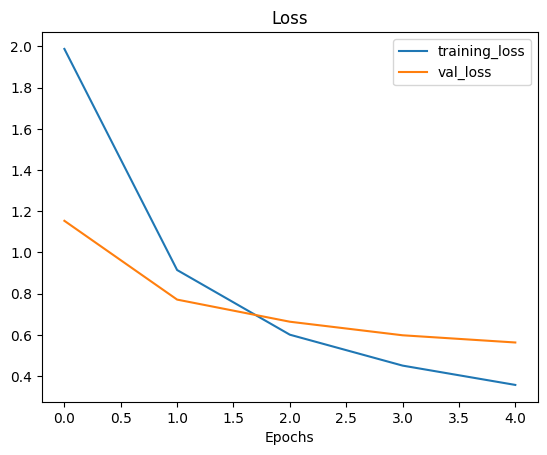

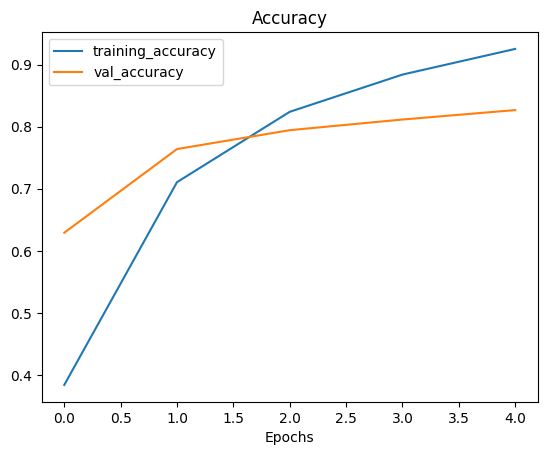

In [13]:
plot_loss_curves(resnet_history)

## Creating and testing EfficientNetB0 TensorFlow Hub Feature Extraction Model

In [14]:
# Create EfficientNetB0 feature extractor model - details on EfficientNet: https://www.googblogs.com/efficientnet-improving-accuracy-and-efficiency-through-automl-and-model-scaling/
efficientnet_model = create_model(model_url=efficientnet_url,
                                  num_classes=train_data_10_percent.num_classes)

# Compile EfficientNet model
efficientnet_model.compile(loss="categorical_crossentropy",
                        optimizer=tf.keras.optimizers.Adam(),
                        metrics=["accuracy"])

# Fit EfficientNet model to 10% of training data
efficientnet_history = efficientnet_model.fit(train_data_10_percent,
                                              epochs=5,
                                              steps_per_epoch=len(train_data_10_percent),
                                              validation_data=test_data,
                                              validation_steps=len(test_data),
                                              callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                                     experiment_name="efficientnetb0")])

Saving TensorBoard log files to: tensorflow_hub/efficientnetb0/20240412-130002%
Epoch 1/5
24/24 [==============================] - 26s 609ms/step - loss: 1.8533 - accuracy: 0.4120 - val_loss: 1.2979 - val_accuracy: 0.7224
Epoch 2/5
24/24 [==============================] - 11s 487ms/step - loss: 1.0792 - accuracy: 0.7507 - val_loss: 0.8672 - val_accuracy: 0.8192
Epoch 3/5
24/24 [==============================] - 11s 485ms/step - loss: 0.7701 - accuracy: 0.8280 - val_loss: 0.7057 - val_accuracy: 0.8248
Epoch 4/5
24/24 [==============================] - 11s 486ms/step - loss: 0.6175 - accuracy: 0.8627 - val_loss: 0.6143 - val_accuracy: 0.8468
Epoch 5/5
24/24 [==============================] - 11s 476ms/step - loss: 0.5214 - accuracy: 0.8813 - val_loss: 0.5584 - val_accuracy: 0.8576


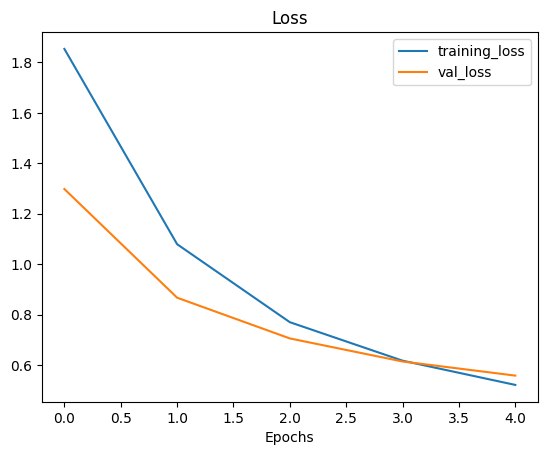

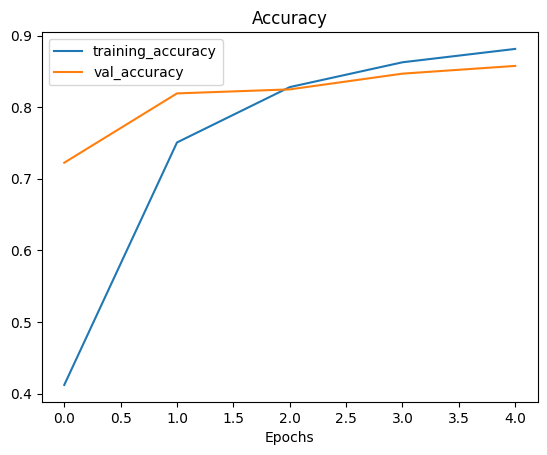

In [15]:
plot_loss_curves(efficientnet_history)

In [16]:
efficientnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (  (None, 1280)              4049564   
 KerasLayer)                                                     
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4062374 (15.50 MB)
Trainable params: 12810 (50.04 KB)
Non-trainable params: 4049564 (15.45 MB)
_________________________________________________________________


In [ ]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (  (None, 2048)              23561152  
 KerasLayer)                                                     
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23581642 (89.96 MB)
Trainable params: 20490 (80.04 KB)
Non-trainable params: 23561152 (89.88 MB)
_________________________________________________________________


In [18]:
# How many layers does our efficientnetb0 feature extractor have?
len(efficientnet_model.layers[0].weights)

309

## Different types of transfer learning

* **"As is" transfer learning** - using an existing model with no changes what so ever (e.g using ImageNet model on 1000 ImageNet classes, none of your own)
* **"Feature extraction"** transfer learning - use the prelearned patterns of an existing model (e.g. EfficientNetB0 trained on ImageNet) and adjust the output layer for your own problem (e.g. 1000 classes -> 10 classes of food)
* **"Fine-tuning" transfer learning** - use the prelearned patterns of an existing model and "fine-tune" many or all of the underlying layers (including new output layers)

## Comparing our models results using TensorBoard

> **Note:** When you upload things to TensorBoard.dev, your experiments are in public.  So, if you're running private experiments, do not upload them to TensorBoard.dev


In [19]:
# Upload TensorBoard dev records
!tensorboard dev upload --logdir ./tensorflow_hub/ \
  --name "EfficientNetB0 vs. ResNet50V2" \
  --description "Comparing two different TF Hub feature extraction model architectures using 10% of the training data" \
  --one_shot


2024-04-12 13:36:49.204268: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-12 13:36:49.204328: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-12 13:36:49.205892: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-12 13:36:50.403140: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
****************************************************************
****************************************************************
****************************************************************

Uploading TensorBoard logs to https://tensorb

See link for alternative [Link](https://colab.research.google.com/github/tensorflow/tensorboard/blob/master/docs/tensorboard_in_notebooks.ipynb#scrollTo=hzm9DNVILxJe)

In [2]:
# Check pout what TensorBoard experiments you have
#!tensorboard dev list

In [1]:
# Delete an experiment
# !tensorboard dev delete --experiment_id .....


In [ ]:
# Confirm the deletion by re-checking what experiments you have left
#!tensorboard dev list